In [1]:
from modelzipper.tutils import *
import matplotlib.pylab as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import copy


TASK_LABELS = {'qa1': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa2': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa3': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa4': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa5': ['Bill', 'Fred', 'Jeff', 'Mary', 'apple', 'football', 'milk'], 
 'qa6': ['no', 'yes'], 
 'qa7': ['none', 'one', 'three', 'two'], 
 'qa8': ['apple', 'football', 'milk', 'nothing'], 
 'qa9': ['no', 'yes'], 
 'qa10': ['maybe', 'no', 'yes'],
 'qa11': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa12': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa13': ['bathroom', 'bedroom', 'garden', 'hallway', 'kitchen', 'office'], 
 'qa14': ['bedroom', 'cinema', 'kitchen', 'office', 'park', 'school'], 
 'qa15': ['cat', 'mouse', 'sheep', 'wolf'], 
 'qa16': ['gray', 'green', 'white', 'yellow'], 
 'qa17': ['no', 'yes'], 
 'qa18': ['no', 'yes'], 
 'qa19': ['e,e', 'e,n', 'e,s', 'n,e', 'n,n', 'n,w', 's,e', 's,s', 's,w', 'w,n', 'w,s', 'w,w'], 
 'qa20': ['bedroom', 'bored', 'garden', 'hungry', 'kitchen', 'thirsty', 'tired']
}


def preprocess_output(output):
    output = output.lower()
    # take only the first sentence from output
    output = output.split('.')[0]
    # filter responses when model tries to generate examples
    output = output.split('<context>')[0]
    output = output.split('<example>')[0]
    output = output.split('Question')[0]
    return output


def compare_answers(target, output, question, task_labels):
    output = preprocess_output(output)
    target = target.lower()
    task_labels = {label.lower() for label in task_labels}

    # extract labels that were mentioned in the question
    labels_in_question = {label for label in task_labels if label in question.lower()}
    # extract labels that were mentioned in the model output
    labels_in_output = {label for label in task_labels if label in output}
    # filter labels in the output to exclude mentioned in the question
    # mentions in questions are never targets
    labels_in_output = labels_in_output - labels_in_question

    # check if the target is the only prediction
    if ',' in target and len(target) > 3: 
        # if target contains multiple subtargets in qa8
        subtargets = target.split(',')
        num_subtargets = len(subtargets)
        if all([t in labels_in_output for t in subtargets]) and len(labels_in_output) == num_subtargets:
            return True
    else:
        if target in labels_in_output and len(labels_in_output) == 1:
            return True

    return False


def eval_fn(pred_path, save_path=None):
    tasks = ['qa2', 'qa3', 'qa4', 'qa5', 'qa6', 'qa7']
    lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k']
    content = auto_read_data(pred_path)

    all_results = dict([(task, dict([(length, []) for length in lengths])) for task in tasks])

    # 填充 DataFrame
    for item in content:
        task, ctx_length = item['task'], item['ctx_length']
        pred, golden, question = item['pred'], item['golden'], item['question']
        all_results[task][ctx_length].append((golden, pred, question, TASK_LABELS[task]))

    return_res = copy.deepcopy(all_results)
    
    for task, item in all_results.items():
        for length, content in item.items():
            acc = np.array([compare_answers(*tmp) for tmp in content]).mean()
            all_results[task][length] = int(acc * 100)
    
    # 转换字典为DataFrame
    df = pd.DataFrame(all_results).T
    df.index.name = 'Task'

    # 重排序：任务按照qa1到qa10排序，长度按4k, 8k, 16k, 32k, 64k, 128k排序
    # df = df.sort_index(axis=0, ascending=True)  # 排序任务名
    # df = df[sorted(df.columns, key=lambda x: int(x.replace('k', '')))]  # 排序长度

    # 绘制热力图
    matplotlib.rc('font', size=14)  # 设置字体大小
    cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)  # 自定义颜色
    figsize = (5, 3.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)  # 创建图形

    # 使用seaborn绘制热力图
    sns.heatmap(df, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f", linewidths=.5, ax=ax)

    # 设置标题和标签
    caption = f"{pred_path.split('/')[-2]}-{pred_path.split('/')[-1].split('.')[0]}"
    ax.set_title(caption)
    ax.set_xlabel('Context size')
    ax.set_ylabel('Tasks')

    # 调整边距以删除多余的白色边框
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    return df, return_res

/mnt/petrelfs/tangzecheng/anaconda3/envs/zecheng/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.7 <<< | AOE Time🕒 2025-01-16 05:18:20


2025-01-16 01:18:22.594 | INFO     | modelzipper.tutils:auto_mkdir:340 - /mnt/petrelfs/tangzecheng/MyRLHF/evaluation/babilong/llama-3_1-8B-Instruct/preliminary already exists!


begin to read data from /mnt/petrelfs/tangzecheng/MyRLHF/inference/babilong/gan/Llama-3.1-8B-Instruct/preds_babilong_gan_nce_global_step100_longmit.jsonl | file size: 2.58 MB | file type: jsonl
      0k  1k  2k  4k  8k  16k  32k  64k
Task                                   
qa2   28  49  46  46  38   26   20   16
qa3   38  47  39  44  34   31   33   32
qa4   42  55  51  55  53   54   49   60
qa5   65  69  68  67  64   61   50   59
qa6   74  81  79  79  62   64   54   56
qa7   11  13  17   8   7    1    2   12


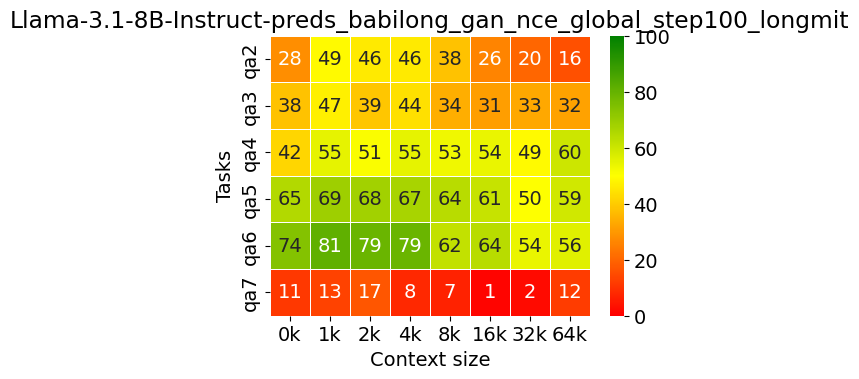

In [2]:
pred_path = '/mnt/petrelfs/tangzecheng/MyRLHF/inference/babilong/gan/Llama-3.1-8B-Instruct/preds_babilong_gan_nce_global_step100_longmit.jsonl'
save_dir = '/mnt/petrelfs/tangzecheng/MyRLHF/evaluation/babilong/llama-3_1-8B-Instruct/preliminary'
# save_dir = '/data/zecheng/acl2025/MyRLHF/evaluation/babilong/llama-3_1-8B-Instruct'
auto_mkdir(save_dir)
save_path = os.path.join(save_dir, "reasoning_prompt_result.png")
 
res, return_res = eval_fn(pred_path, None)
print(res)

In [3]:
res

,0k,1k,2k,4k,8k,16k,32k,64k
Task,,,,,,,,
qa2,28,49,46,46,38,26,20,16
qa3,38,47,39,44,34,31,33,32
qa4,42,55,51,55,53,54,49,60
qa5,65,69,68,67,64,61,50,59
qa6,74,81,79,79,62,64,54,56
qa7,11,13,17,8,7,1,2,12


In [7]:
from datasets import load_dataset

train_data = load_dataset("RMT-team/babilong-train-5k-samples", "2k")

In [14]:
train_data['qa7'][0]

{'input': 'The mechanism of the reverse turn is exactly the same as that of the\nturn to the right, except that it is accomplished with the other foot,\nand in the opposite direction. There is no better or more efficacious exercise to perfect the Boston,\nthan that which is made up of one complete turn to the right, a measure\nto reverse, and a complete turn to the left. This should be practised\nuntil one has entirely mastered the motion and rhythm of the dance. Mary went back to the bedroom. John went to the garden. Sandra grabbed the apple there. The\nwriter has used this exercise in all his work, and finds it not only\nhelpful and interesting to the pupil, but of special advantage in\nobviating the possibility of dizziness, and the consequent\nunpleasantness and loss of time. [Illustration]\n\nAfter acquiring a degree of ease in the execution of these movements to\nMazurka music, it is advisable to vary the rhythm by the introduction of\nSpanish or other clearly accented Waltz musi